In [2]:
import random
import numpy as np
from collections import deque
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import math


In [3]:
def matrix_to_tuple(matrix):
    return (matrix[0][1], matrix[0][2], matrix[1][2])

# B is the inverse of A
A = np.array([[1, 1, 0], [0, 1, 0], [0, 0, 1]])
B = np.array([[1, -1, 0], [0, 1, 0], [0, 0, 1]])

# C is the inverse of D
C = np.array([[1, 0, 0], [0, 1, 1], [0, 0, 1]])
D = np.array([[1, 0, 0], [0, 1, -1], [0, 0, 1]])

identity = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

# together, A, B, C, and D generate the heisenberg group

In [4]:

def epsilon_greedy_search(Epsilon, qtable, state):
    if (random.random() < Epsilon):
        # 0 is 'apply matrix A', 1 is 'apply matrix B'
        # 2 is 'apply matrix C', 3 is 'apply matrix D'
        return random.choice([0, 1, 2, 3])
    else:
        # get the best move for the current state
        return best_move_for_a_state(Q_table=qtable, state=state)
    
# I would like to return the best move for a given state
def best_move_for_a_state(Q_table, state):
    # vals = Q_table[(state[0][1], state[0][2], state[1][2])]

    apply_A = state @ A
    apply_B = state @ B
    apply_C = state @ C
    apply_D = state @ D

    vals = [0, 0, 0, 0]
    vals[0] = Q_table[matrix_to_tuple(apply_A)]
    vals[1] = Q_table[matrix_to_tuple(apply_B)]
    vals[2] = Q_table[matrix_to_tuple(apply_C)]
    vals[3] = Q_table[matrix_to_tuple(apply_D)]

    # if we haven't visited this state before, return a random choice of 0, 1, 2, or 3
    if vals==[0, 0, 0, 0]:
        return random.choice([0, 1, 2, 3])
    
    # if we have visited this state before, return the current best choice
    return np.argmax(vals)

# over a given state, return the maximum value of the table for that state
def max_a_prime(Q_table, state):
    apply_A = state @ A
    apply_B = state @ B
    apply_C = state @ C
    apply_D = state @ D

    vals = [0, 0, 0, 0]
    vals[0] = Q_table[matrix_to_tuple(apply_A)]
    vals[1] = Q_table[matrix_to_tuple(apply_B)]
    vals[2] = Q_table[matrix_to_tuple(apply_C)]
    vals[3] = Q_table[matrix_to_tuple(apply_D)]
    
    return max(vals)

In [5]:
max_reward = 10000
step_penalty = -10
def getReward(matrix):
    if (matrix==identity).all():
        return max_reward
    else:
        return step_penalty

In [6]:
df = pd.read_csv("../Data_Generation/Data_files/heisenberg_data.csv")

In [7]:
def get_next_step(oldObs, action):
    # action is always either 0, 1, 2, or 3
    next_state = []
    if action==0:
        next_state = oldObs @ A
    elif action==1:
        next_state = oldObs @ B
    elif action==2:
        next_state = oldObs @ C
    else:
        next_state = oldObs @ D
    curReward = getReward(next_state)
    done = curReward==max_reward
    return (next_state, curReward, done)
    

In [8]:
# adapted from CS 540 Spring 2023 HW 10
EPISODES = 300000
# EPISODES = 20000
LEARNING_RATE = .9
DISCOUNT_FACTOR = .999
EPSILON = 1
EPSILON_DECAY = .9999

random.seed(1)

# starts with an estimate of zero reward for each state.
# adapted from ChatGPT
Q_table = defaultdict(lambda: 0)

# TODO make sure this change worked
episode_reward_record = deque(maxlen=500)

for i in range(EPISODES):
    episode_reward = 0
    done = False
    # choose a random starting row
    # adapted from https://stackoverflow.com/questions/15923826/random-row-selection-in-pandas-dataframe
    cur_row = df.sample(1)
    obs = np.array([
        [1, int(cur_row['val1']), int(cur_row['val2'])], 
        [0, 1, int(cur_row['val3'])], 
        [0, 0, 1]
        ])

    index = 1

    while (not done):
        # perform an epsilon greedy action 
        # Q(s, a) = (1-LEARNING_RATE)Q(s, a) + (LEARNING_RATE)(r + DISCOUNT_FACTOR(max a'(Q(s', a'))))
        action = epsilon_greedy_search(Epsilon=EPSILON, qtable=Q_table, state=obs)

        oldObs = obs
        obs,reward,done = get_next_step(oldObs, action)

        if (obs==identity).all():
            Q_table[matrix_to_tuple(obs)] = max_reward
        else: 
            Q_table[matrix_to_tuple(obs)] = (1-LEARNING_RATE) * Q_table[matrix_to_tuple(obs)] + (LEARNING_RATE) * (reward + DISCOUNT_FACTOR * (max_a_prime(Q_table, obs)))

        episode_reward += reward # update episode reward

        index += 1
        # if we take more than 100 steps, end this iteration early (we are probably not making progress)
        if index > 100:
            done=True

    # decay the epsilon
    EPSILON *= EPSILON_DECAY

    # record the reward for this episode
    episode_reward_record.append(episode_reward) 

    if i%500 ==0 and i>0:
        print("Average reward for the last 500 iterations: " + str(sum(list(episode_reward_record))/500))
        print("epsilon: " + str(EPSILON) )



Average reward for the last 500 iterations: -957.72
epsilon: 0.9511319235669539
Average reward for the last 500 iterations: -684.06
epsilon: 0.9047424102692004
Average reward for the last 500 iterations: -157.4
epsilon: 0.8606154505570021
Average reward for the last 500 iterations: 346.56
epsilon: 0.8186406930090225
Average reward for the last 500 iterations: 1402.9
epsilon: 0.7787131683686925
Average reward for the last 500 iterations: 3253.38
epsilon: 0.7407330270401349
Average reward for the last 500 iterations: 4535.3
epsilon: 0.7046052893871948
Average reward for the last 500 iterations: 6268.24
epsilon: 0.6702396082111141
Average reward for the last 500 iterations: 7123.84
epsilon: 0.6375500428128791
Average reward for the last 500 iterations: 8003.78
epsilon: 0.6064548440752141
Average reward for the last 500 iterations: 8969.9
epsilon: 0.576876250026757
Average reward for the last 500 iterations: 9059.42
epsilon: 0.548740291377179
Average reward for the last 500 iterations: 935

In [9]:
Q_table[matrix_to_tuple(C@C@C@C)]

9920.119920019999

In [10]:
Q_table[matrix_to_tuple(C@C)]

9960.02

In [11]:
print(A)
print(A@A)
print(A@A@A)
print(A@A@A@C)

[[1 1 0]
 [0 1 0]
 [0 0 1]]
[[1 2 0]
 [0 1 0]
 [0 0 1]]
[[1 3 0]
 [0 1 0]
 [0 0 1]]
[[1 3 3]
 [0 1 1]
 [0 0 1]]


In [12]:
# test with the other dataframe. 
test_df = pd.read_csv("../Data_Generation/Data_files/heisenberg_data_test.csv")

In [13]:
cur_matrix = np.array([[1, int(cur_row['val1']), int(cur_row['val2'])], [0, 1, int(cur_row['val3'])], [0, 0, 1]])

In [29]:
def matrix_to_num_steps(cur_matrix):
    index = 1
    for i in range(50):
        if (cur_matrix==identity).all():
            return i
        outputs = [0, 0, 0, 0]
        outputs[0] = Q_table[matrix_to_tuple(cur_matrix@ A)]
        outputs[1] = Q_table[matrix_to_tuple(cur_matrix@ B)]
        outputs[2] = Q_table[matrix_to_tuple(cur_matrix@ C)]
        outputs[3] = Q_table[matrix_to_tuple(cur_matrix@ D)]
        index = np.argmax(outputs)
        if index==0:
            cur_matrix = cur_matrix @ A
        elif index==1:
            cur_matrix = cur_matrix @ B
        elif index==2:
            cur_matrix = cur_matrix @ C
        elif index==3:
            cur_matrix = cur_matrix @ D
    return 100

In [30]:
def test_Q_learning(row):
    cur_matrix = np.array([[1, int(row['val1']), int(row['val2'])], [0, 1, int(row['val3'])], [0, 0, 1]])
    return matrix_to_num_steps(cur_matrix)

test_df['num_moves_Q_learning_needs'] = test_df.apply(test_Q_learning, axis=1)

In [31]:
print("The proportion of starting positions in the test dataset that we can find a route to the origin that's <50 steps: ")
sum(test_df['num_moves_Q_learning_needs']!=100)/test_df.shape[0]

The proportion of starting positions in the test dataset that we can find a route to the origin that's <50 steps: 


0.9927992799279928

In [32]:
print("Of these, the proportion of times where we learned a path that was < 20 moves: ")
# encouraging because all of these were generated as sequences of 30 moves
# so we've found significantly faster paths back to the origin for almost all moves that we find a path to the origin 
sum(test_df['num_moves_Q_learning_needs']<20)/sum(test_df['num_moves_Q_learning_needs']!=100)

Of these, the proportion of times where we learned a path that was < 20 moves: 


0.927470534904805

In [50]:
filtered_df = test_df[test_df['num_moves_Q_learning_needs']!=100]

(9927, 5)

In [51]:
# because of random generation of points, we have some duplicates
filtered_df = filtered_df[filtered_df.duplicated(keep=False)]

(2823, 5)

In [63]:
filtered_df = filtered_df.reset_index(drop=True)

In [64]:
def first_matrix_to_apply(row):
    outputs = [0, 0, 0, 0]
    cur_matrix = np.array([
        [1, int(row['val1']), int(row['val2'])], 
        [0, 1, int(row['val3'])], 
        [0, 0, 1]
        ])
    outputs[0] = Q_table[matrix_to_tuple(cur_matrix@ A)]
    outputs[1] = Q_table[matrix_to_tuple(cur_matrix@ B)]
    outputs[2] = Q_table[matrix_to_tuple(cur_matrix@ C)]
    outputs[3] = Q_table[matrix_to_tuple(cur_matrix@ D)]
    return np.argmax(outputs)

filtered_df['first_move_by_Q_learning'] = filtered_df.apply(first_matrix_to_apply, axis=1)

In [65]:
bound = int(filtered_df.shape[0] * 0.6)
plus_one = bound+1
filtered_df = filtered_df.drop_duplicates()
train = filtered_df.iloc[1:bound]
test = filtered_df.iloc[plus_one:filtered_df.shape[0]]

In [57]:
Q_table

defaultdict(<function __main__.<lambda>()>,
            {(-4, 43, -11): 9653.03922208888,
             (-3, 43, -11): 9329.870435055516,
             (-5, 43, -11): 9682.324669857982,
             (-4, 39, -10): 8298.94439377789,
             (-4, 47, -12): 9627.747919743284,
             (-3, 47, -12): 7777.941605507661,
             (-5, 47, -12): 0,
             (-4, 51, -13): 9568.711664609556,
             (-3, 51, -13): 9508.863891559882,
             (-5, 51, -13): 9562.035032029633,
             (-4, 55, -14): -9.0,
             (-6, 51, -13): 9541.816446041186,
             (-5, 46, -12): 9662.706447476488,
             (-5, 56, -14): 0,
             (-3, 55, -14): -9.0,
             (-5, 55, -14): 0,
             (-4, 59, -15): 0,
             (-2, 55, -14): 0,
             (-3, 52, -13): -9.9,
             (-3, 58, -15): 0,
             (-2, 52, -13): -9.0,
             (-4, 52, -13): -9.0,
             (-3, 49, -12): -9.0,
             (-5, 52, -13): 0,
             (-4, 48

In [66]:
def get_Q_value(row):
    return Q_table[(int(row['val1']), 
    int(row['val2']), 
    int(row['val3']))]

In [67]:
train_values = train.copy(deep=True)
test_values = test.copy(deep=True)

In [68]:
train_values['Q_table_val'] = train_values.apply(get_Q_value, axis=1)
test_values['Q_table_val'] = test_values.apply(get_Q_value, axis=1)

In [69]:
train_values.to_csv("../Data_Generation/Data_files/Q_moves_scores.csv", index=False)
test_values.to_csv("../Data_Generation/Data_files/Q_moves_scores_test.csv", index=False)

In [27]:
train_values

,val1,val2,val3,last_matrix,num_moves_Q_learning_needs,first_move_by_Q_learning,Q_table_val
2,1,-7,-1,4,9,0,9800.897604
3,-4,40,-8,2,13,1,9659.474399
4,-1,-14,5,3,9,1,9800.897604
5,6,-16,-4,4,9,1,9800.897604
6,-2,-3,-2,2,7,0,9840.558881
...,...,...,...,...,...,...,...
5993,-2,41,-8,4,17,3,9474.224655
5994,0,-5,-2,2,7,0,9840.558881
5995,-3,-1,1,3,3,0,9920.119920
5996,4,-15,-6,1,9,1,9800.897604


In [222]:
row = dict()
row['val1'], row['val2'], row['val3'] = matrix_to_tuple(A@A@A@C@B@D@B@D@B)

In [223]:
first_matrix_to_apply(row)

2

In [225]:
outputs = [0, 0, 0, 0]

cur_matrix = A@A@A@A@A@D@B
print(cur_matrix)

outputs[0] = Q_table[matrix_to_tuple(cur_matrix@ A)]
outputs[1] = Q_table[matrix_to_tuple(cur_matrix@ B)]
outputs[2] = Q_table[matrix_to_tuple(cur_matrix@ C)]
outputs[3] = Q_table[matrix_to_tuple(cur_matrix@ D)]
outputs

[[ 1  4 -5]
 [ 0  1 -1]
 [ 0  0  1]]


[9880.299600299879, 9880.299600299879, 9880.299600299879, 9840.55888139888]

In [226]:
results = []

results.append((matrix_to_num_steps(A@A@A@A), 3))
results.append((matrix_to_num_steps(A@A@A@A@A), 4))
results.append((matrix_to_num_steps(B@B@B@B), 3))
results.append((matrix_to_num_steps(B@B@B@B@B), 4))
results.append((matrix_to_num_steps(C@C@C@C), 3))
results.append((matrix_to_num_steps(C@C@C@C@C), 4))
results.append((matrix_to_num_steps(D@D@D@D), 3))
results.append((matrix_to_num_steps(D@D@D@D@D), 4))
results.append((matrix_to_num_steps(A@C), 1))
results.append((matrix_to_num_steps(A@C@C), 2))
results.append((matrix_to_num_steps(B@C), 1))
results.append((matrix_to_num_steps(B@C@C), 2))

results

[(3, 3),
 (4, 4),
 (3, 3),
 (4, 4),
 (3, 3),
 (4, 4),
 (3, 3),
 (4, 4),
 (1, 1),
 (2, 2),
 (1, 1),
 (2, 2)]

In [229]:
np.array([[1, 1, -7], [0, 1, -1], [0, 0, 1]])@C@A@C

array([[ 1,  2, -4],
       [ 0,  1,  1],
       [ 0,  0,  1]])

In [230]:
Q_table[matrix_to_tuple(A@C@C@C@C@B@D@B@D@C@A)]

print(Q_table[matrix_to_tuple(A@C@C@C@C@B@D@B@D@C@A)])
print(Q_table[matrix_to_tuple(A@C@C@C@C@B@D@B@D@C@B)])
print(Q_table[matrix_to_tuple(A@C@C@C@C@B@D@B@D@C@C)])
print(Q_table[matrix_to_tuple(A@C@C@C@C@B@D@B@D@C@D)])

9860.41930069958
9820.718322517481
9860.41930069958
9820.718322517481


In [231]:
problem_cases = test_df[test_df['num_moves_Q_learning_needs']==100]

In [232]:
first_row = problem_cases.iloc[1]

In [233]:
test_mat = np.array([[1, first_row['val1'], first_row['val2']], [0, 1, first_row['val3']], [0, 0, 1]])

In [234]:
def matrix_to_next_matrix(mat):
    outputs = [0, 0, 0, 0]

    outputs[0] = Q_table[matrix_to_tuple(mat@ A)]
    outputs[1] = Q_table[matrix_to_tuple(mat@ B)]
    outputs[2] = Q_table[matrix_to_tuple(mat@ C)]
    outputs[3] = Q_table[matrix_to_tuple(mat@ D)]

    index = np.argmax(outputs)
    if index==0:
        cur_matrix = mat @ A
    elif index==1:
        cur_matrix = mat @ B
    elif index==2:
        cur_matrix = mat @ C
    elif index==3:
        cur_matrix = mat @ D

    
    return cur_matrix

In [235]:
def do_we_loop(seen, matrix):
    for i in range(20):
        seen.add(matrix_to_tuple(matrix))
        matrix = matrix_to_next_matrix(matrix)
        if matrix_to_tuple(matrix) in seen: 
            return True
            # return (matrix, i)
    # return "We do not loop"
    return False


In [236]:
seen = set()
do_we_loop(seen, test_mat)

False

In [237]:
def add_if_loop_to_df(row): 
    test_mat = np.array([[1, row['val1'], row['val2']], [0, 1, row['val3']], [0, 0, 1]])
    seen = set()
    return do_we_loop(seen, test_mat)
problem_cases['do_we_loop'] = problem_cases.apply(add_if_loop_to_df, axis=1)

C:\Users\16089\AppData\Local\Temp\ipykernel_24624\2113995181.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  problem_cases['do_we_loop'] = problem_cases.apply(add_if_loop_to_df, axis=1)


In [238]:
sum(problem_cases['do_we_loop'])/problem_cases.shape[0]
# we almost always loop within 20 moves

0.3387096774193548

In [239]:
def min_a_b_sqrt_c(row):
    return min(abs(row['val1']), 
    abs(row['val3']), 
    math.sqrt(abs(row['val2'])))

def max_a_b_sqrt_c(row):
    return max(abs(row['val1']), 
    abs(row['val3']), 
    math.sqrt(abs(row['val2'])))

test_df['min_a_b_sqrt_c'] = test_df.apply(min_a_b_sqrt_c, axis=1)
test_df['max_a_b_sqrt_c'] = test_df.apply(max_a_b_sqrt_c, axis=1)

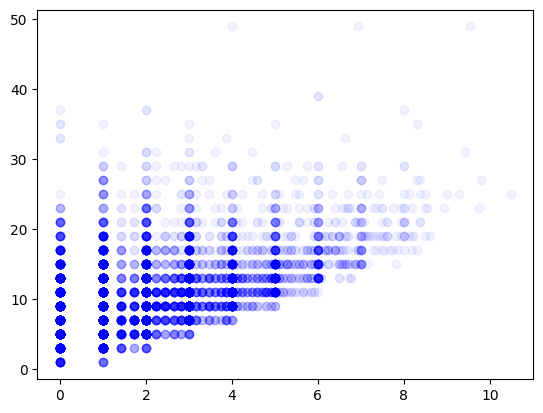

In [240]:
non_problems = test_df[test_df['num_moves_Q_learning_needs']!=100]
plt.scatter(non_problems['min_a_b_sqrt_c'], non_problems['num_moves_Q_learning_needs'], c="blue", alpha=0.05)

In [241]:
# gotta count the number of commutators
# given a sequence, want to count the number of commutators
# a sequence like AACCBBDD has 1 commutator. ACBDACBD has 2 commutators. I think I've got the right def for commutator

In [242]:
non_problems.to_csv('../Visualizations/viz_a_b_sqrt_c.csv', index=False)

In [243]:
print((A @ C @ B @ D))
print(A@A@A@C@C@C@B@B@B@D@D@D)
# print(A@A@A@C@C@B@B@B@D@D)

[[1 0 1]
 [0 1 0]
 [0 0 1]]
[[1 0 9]
 [0 1 0]
 [0 0 1]]


In [244]:
print(C @ A @ D @ B)
print(C@C@C@A@A@A@D@D@D@B@B@B)
# print(A@A@A@C@C@C@B@B@B@D@D@D)
# print(A@A@A@C@C@B@B@B@D@D)

[[ 1  0 -1]
 [ 0  1  0]
 [ 0  0  1]]
[[ 1  0 -9]
 [ 0  1  0]
 [ 0  0  1]]


In [245]:
def Q_table_to_df_and_save(my_Q_table):
    # this will create a dataframe from the Q_table and then save it
    data = {
        'a': [],
        'c': [],
        'b' : [],
        'value': []
    }
    Q_table_df = pd.DataFrame(data)
    for i in dict(my_Q_table):
        df2 = pd.DataFrame([[
            i[0],
            i[1],
            i[2],
            my_Q_table[i]
            ]],
            columns=['a', 'c', 'b', 'value'])
        Q_table_df = pd.concat([df2, Q_table_df])

    Q_table_df.to_csv("../Visualizations/Q_table_df.csv", index=False)

In [246]:
# Q_table_to_df_and_save(Q_table)
# turns a Q_table into a dataframe and saves it

In [247]:
# Q_table_new = pd.read_csv("../Data_Generation/Data_files/Q_table_df.csv")

In [248]:
def df_to_Q_table(df):
    my_new_Q_table = defaultdict(lambda: 0)

    for index in range(len(df)):
        row = df.iloc[index]
        a = int(row['a'])
        b = int(row['b'])
        c = int(row['c'])
        my_new_Q_table[(a, c, b)] = row['value']

    return my_new_Q_table